In [31]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g = Gaussian1DKernel(stddev=5)

pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23
from pcygni_profile import PcygniCalculator
from scipy.interpolate import interp1d
import astropy.units as units
import astropy.constants as csts
import math

def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'

def forbidden(ax): 
    top = 10
    #define telluric region
    ax.fill_between([13100, 14400], [-5*10**(-16), -5*10**(-16)], [top*10**(-16), top*10**(-16)], color='grey', alpha=0.6 )
    ax.fill_between([17550, 19200], [-5*10**(-16), -5*10**(-16)], [top*10**(-16), top*10**(-16)], color='grey', alpha=0.6 )

    #poorly constrained regions
    ax.fill_between([5330, 5740], [-5*10**(-16), -5*10**(-16)] , [top*10**(-16), top*10**(-16)], color='grey', alpha=0.3   )
    ax.fill_between([9940, 10200], [-5*10**(-16), -5*10**(-16)], [top*10**(-16), top*10**(-16)], color='grey', alpha=0.3  )

    #define absorbtion feature
    #ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
    ax.fill_between([3000, 4000], [-5*10**(-16), -5*10**(-16)], [top*10**(-16), top*10**(-16)], color='grey', alpha=0.3  )


In [32]:
import numba
from astropy.modeling import models

def bb(wav, T, N):
    wav = wav
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5)*(math.e**b - 1.0) )
    return N*intensity

def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, vref=0.2, ve=0.2, t0 = 120960): 
    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA)#, _lam_min=7000, _lam_max=13000)
    
    cyg = prof_calc.calc_profile_Flam( npoints=25 )  
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)    
    return inter(wl)

@numba.njit(fastmath=True)
def temp(wav,T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )
    
@numba.njit(fastmath=True)
def gaussian(wav, amp, mu, sigma): 
    return amp*np.exp(-(wav-mu)**2/(2*sigma**2))
    
def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32,
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vref=0., t0=120960, lam=10506.3653): #blackbody
    #a = 2.0*h*pi*c**2
    #b = h*c/(wav*k*T)
    #intensity = a/ ( (wav**5)*(np.exp(b) - 1.0) )
    intensity = temp(wav, T)
    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    #correction = p_cygni_line_corr(wav, v_out, v_phot, tau, lam, vref=vref, ve=ve, t0=t0)
    #correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    #gau1 = models.Gaussian1D.evaluate(wav, 1e-17*amp1, cen1, sig1)
    #gau2 = models.Gaussian1D.evaluate(wav, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity*correction
    return N*intensity+gau1+gau2


def residual(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2)
    
    if data is None:
        return model
    return (model - data)/error

import lmfit

def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 
    #def integral(x): 
    #    return np.sqrt(1-v**2) * 1/(1+v*np.cos(x))*np.sin(x)*np.cos(x)**2 * (3) 

    #corr = np.zeros_like(vphot)
    #for i,v in enumerate(vphot):
    #    delta = quad(integral, 0, np.pi/2)[0]
    #    corr[i] = delta**4
    delta = 1-2/3*11/10*vphot
    corr = delta**4
    
    theta = 2*np.sqrt(corr*N*10**(7)/(1-vphot))

    v = vphot*c #factor of 2
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23)
    return D_mpc

n_days = [1.427, 2.417, 3.413, 4.403]

C:\Users\asnep\Downloads\Kilonova\pcygni_profile.py:489: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, mode))[0]
No handles with labels found to put in legend.


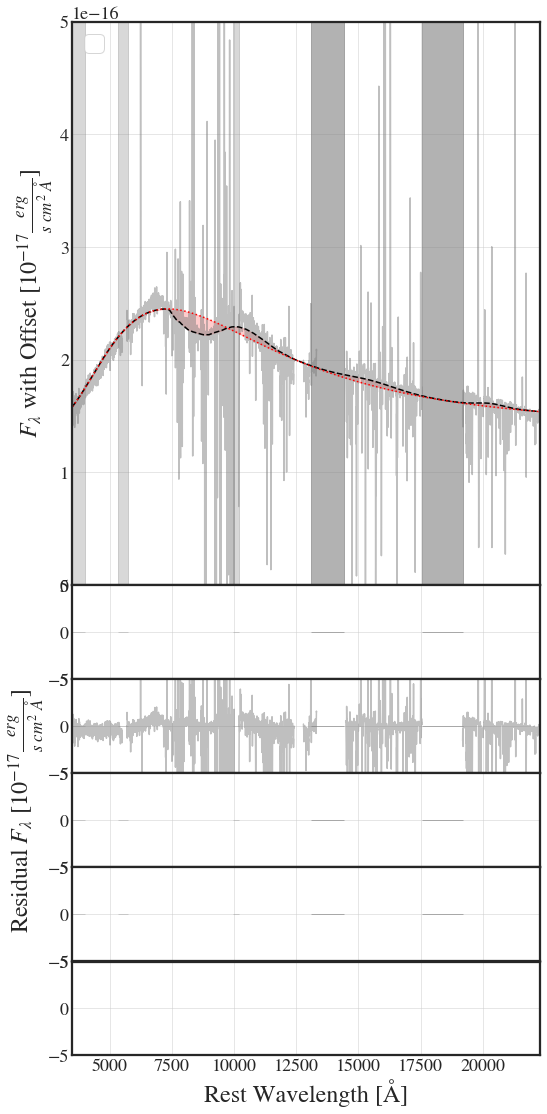

In [33]:
path = './spectra_full' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

reset_plt(18,24)
fig,ax = plt.subplots(figsize=(8,16),nrows=6, gridspec_kw={'height_ratios': [6, 1, 1, 1, 1, 1]}, sharex=True )

#fit_res = ["./data/OB1/OB1_low_v.pkl", './data/OB2_init_no_gaussian_low_v.pkl',
#           "./data/OB3_init_no_gaussian_high_v.pkl", "./data/OB4/OB4_3.pkl"]
#fit_res = ["./data/OB1/OB1_3_peaks_XL.pkl", "./data/OB2/OB2_3_peaks_XL.pkl", 
#        "./data/OB3/OB3_3_peaks_XL.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl", "./Data/OB5/OB4_3_peaks_XL.pkl"] 

fit_res = ["./data/OB1/OB1_3_peaks_XL_3.pkl", "./data/OB2/OB2_3_peaks_XL_2.pkl", 
         "./data/OB3/OB3_3_peaks_XL_4.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl", 
         "./Data/OB5/OB5_3_peaks_XL_3.pkl" ] 
fac = 1e17

off_set = [2.1e-16, 1.4e-16, 0.7e-16, 0]
ratio_lim = 0.5

for i in [1]: #None:#[1,2,3,4]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    
    # exc_reg_2 = (x[:,0] > 3600) & (x[:,0] < 22500)
    mask = ((wl > 5500) & (wl < 5700)) | ((wl > 10000) & (wl < 10200)) | ((wl > 12400) & (wl < 12800)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19200))
    flux2[mask] = np.nan
    error2[mask] = np.nan
    
    #wl2, flux2, error2,_ = bin_spectrum(wl, flux, error, ~exc_reg_2, 20)

    pickle_in = open(fit_res[i],"rb")
    emcee_res = pickle.load(pickle_in)
    flux_fit = residual(emcee_res.params, wl2*1e-10)

    ax[0].plot(wl2, convolve(flux2, g, fill_value=np.nan)+off_set[i], 
             color='grey', alpha=0.5)

    ax[0].plot(wl, flux_fit+off_set[i], color='k', ls='--')
    flux_fit_bb = bb( wl*1e-10, emcee_res.params['T'], emcee_res.params['N'])
    ax[0].plot(wl, flux_fit_bb+off_set[i], color='red', ls='dotted')
    ax[0].fill_between(wl, flux_fit+off_set[i], flux_fit_bb+off_set[i], color='red', alpha=0.2)
    
    
    ax[i+1].plot(wl2,#[(ratio < ratio_lim) & (ratio>-ratio_lim)], 
                 fac*(convolve(flux2, g, fill_value=np.nan)-flux_fit), 
                color='grey', alpha=0.5)

forbidden(ax[0]), forbidden(ax[1]), forbidden(ax[2]), forbidden(ax[3]), forbidden(ax[4])

plt.xlabel('Rest Wavelength [Å]'), ax[0].set_ylabel(r'$F_\lambda $ with Offset $ [10^{-17} \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax[0].ticklabel_format(axis='x', style='plain')
ax[0].set_xlim(3500,22300), ax[0].set_ylim(0, 5e-16), ax[0].legend(frameon=True)
ax[1].set_ylim(-0.5e-16*fac,0.5e-16*fac), ax[2].set_ylim(-0.5e-16*fac,0.5e-16*fac), 
ax[3].set_ylim(-0.5e-16*fac,0.5e-16*fac), ax[4].set_ylim(-0.5e-16*fac,0.5e-16*fac),
ax[5].set_ylim(-0.5e-16*fac,0.5e-16*fac)


#fig.subplots_adjust(hspace=0, wspace=0)
fig.text(0.03, 0.28, r'Residual $F_\lambda$ $ [10^{-17} \frac{erg}{s \ cm^2 \ Å} ] $', va='center', rotation='vertical')

#plt.legend(frameon=True)
#plt.xscale('log') 
plt.tight_layout()
plt.subplots_adjust(hspace = .001)

#plt.savefig('Pictures/All_epochs_3.png', dpi=300)

In [36]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

from astropy.io import fits
from scipy import interpolate
import numpy as np
import pcygni_profile
import astropy.units as u
import astropy.constants as c
from astropy.cosmology import Planck15 as cosmo
from astropy.modeling.blackbody import blackbody_lambda
from astropy.modeling import models
from scipy.signal import medfilt


__all__ = ["get_data", "bb_fit", "pcyg", "residual", "find_nearest", "bin_spectrum"]


def get_data(path, OB, filter_bad = False):

    fac = 10
    # print(int(OB[2:]))
    # if int(OB[2:]) > 5:
    #     fac = 1


    f = fits.open("%s/UVB%s.fits"%(path, OB))
    # print(f[1].columns)
    wl = fac*f[1].data.field("WAVE").flatten()
    q = f[1].data.field("QUAL").flatten()
    mask_wl = (wl > 3200) & (wl < 5600)
    mask_qual = ~q.astype("bool")
    flux = interpolate.interp1d(wl[mask_qual], f[1].data.field("FLUX").flatten()[mask_qual], bounds_error=False, fill_value=0)
    error = interpolate.interp1d(wl[mask_qual], f[1].data.field("ERR").flatten()[mask_qual], bounds_error=False, fill_value=0)
    wl_plot = wl[mask_wl]
    flux = flux(wl_plot)
    error = error(wl_plot)
    wl_UVB = wl_plot
    flux_UVB = flux
    error_UVB = error

    f = fits.open("%s/VIS%s.fits"%(path, OB))
    wl = fac*f[1].data.field("WAVE").flatten()
    q = f[1].data.field("QUAL").flatten()
    try:
        t = f[1].data.field("TRANS").flatten()
    except:
        t = np.ones_like(f[1].data.field("QUAL").flatten())
    mask_wl = (wl > 5600) & (wl < 10200)
    mask_qual = ~q.astype("bool")

    flux = interpolate.interp1d(wl[mask_qual], f[1].data.field("FLUX").flatten()[mask_qual], bounds_error=False, fill_value=0)
    error = interpolate.interp1d(wl[mask_qual], f[1].data.field("ERR").flatten()[mask_qual], bounds_error=False, fill_value=0)
    wl_plot = wl[mask_wl]
    flux = flux(wl_plot)/t[mask_wl]
    error = error(wl_plot)/t[mask_wl]
    wl_VIS = wl_plot
    flux_VIS = flux
    error_VIS = error

    f = fits.open("%s/NIR%s.fits"%(path, OB))
    try:
        f_nod = fits.open("%s/NIR%s_NOD.fits"%(path, OB))
    except:
        f_nod = fits.open("%s/NIR%s.fits"%(path, OB))
    wl = fac*f[1].data.field("WAVE").flatten()
    f[1].data["FLUX"] = np.concatenate((f[1].data["FLUX"].flatten()[(wl <= 22500)], f_nod[1].data["FLUX"].flatten()[(wl > 22500)]))
    f[1].data["ERR"] = np.concatenate((f[1].data["ERR"].flatten()[(wl <= 22500)], f_nod[1].data["ERR"].flatten()[(wl > 22500)]))

    q = f[1].data.field("QUAL").flatten()
    try:
        t = f[1].data.field("TRANS").flatten()
    except:
        t = np.ones_like(f[1].data.field("QUAL").flatten())
    mask_wl = (wl > 10200)
    mask_qual = ~q.astype("bool")
    flux = interpolate.interp1d(wl[mask_qual], f[1].data.field("FLUX").flatten()[mask_qual], bounds_error=False, fill_value=0)
    error = interpolate.interp1d(wl[mask_qual], f[1].data.field("ERR").flatten()[mask_qual], bounds_error=False, fill_value=0)
    wl_plot = wl[mask_wl]
    flux = flux(wl_plot)/t[mask_wl]
    error = error(wl_plot)/t[mask_wl]
    wl_NIR = wl_plot
    flux_NIR = flux
    error_NIR = error



    wl = np.concatenate((wl_UVB, wl_VIS, wl_NIR))
    flux = np.concatenate((flux_UVB, flux_VIS, flux_NIR))
    error = np.concatenate((error_UVB, error_VIS, error_NIR))

    if filter_bad:

        wl, flux, error = filter_bad_values(wl, flux, error)

    return wl, flux, error


def filter_bad_values(wl, flux, error):
    medfilter = medfilt(flux, 501)
    mask = np.logical_and(abs(flux - medfilter) < 3*error, ~np.isnan(flux))
    f = interpolate.interp1d(wl[mask], flux[mask], bounds_error=False, fill_value = np.nan)
    g = interpolate.interp1d(wl[mask], error[mask], bounds_error=False, fill_value = np.nan)
    return wl, f(wl), g(wl)


def bb_fit(T, r, wl):
    dL = cosmo.luminosity_distance(0.009783).to(u.cm)
    bb = blackbody_lambda(wl, T) * np.pi * u.sr * (r*u.cm/dL)**2
    return bb.value


def pcyg(t0, vmax, vphot, tauref, vref, ve, lam0, wl):

    prof_calc = pcygni_profile.PcygniCalculator(t=t0 * u.s, vmax=vmax * c.c,
                                 vphot=vphot * c.c, tauref=tauref, vref=vref * c.c, ve=ve * c.c,
                                 lam0=lam0 * u.AA)

    x, pcyg = prof_calc.calc_profile_Flam(npoints=25, mode="both")
    f = interpolate.interp1d(x, pcyg, bounds_error=False, fill_value=1)
    return f(wl)

def residual(pars, t, data=None, error=None):
    """
    Objective function which calculates the residuals. Using for minimizing.
    """

    # Unpack parameter values
    if type(pars) is list or isinstance(pars, np.ndarray):
        T, R, beta = pars[0], pars[1], pars[2]
        t0, vmax, tauref1, tauref2, tauref3, vref, ve, occult1, occult2 = pars[3], pars[4], pars[5], pars[6], pars[7], pars[8], pars[9], pars[10], pars[11]
        amp1, amp2, cen1, cen2, sig1, sig2 = pars[12], pars[13], pars[14], pars[15], pars[16], pars[17]
    else:
        v = pars.valuesdict()
        T, R, beta = v["T"], v["R"], v["beta"]
        t0, vmax, tauref1, tauref2, tauref3, vref, ve, occult1, occult2 = v["t0"], v["vmax"], v["tauref1"], v["tauref2"], v["tauref3"], v["vref"], v["ve"], v["occult1"], v["occult2"]
        amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    # Construct model components
    # P-cygnis
    # Sr
    # 10506.3653
    pcyg_prof1 = pcyg(t0, vmax, beta, tauref1, vref, ve, 4077.709, t)
    pcyg_prof2 = pcyg(t0, vmax, beta, tauref1, vref, ve, 4215.519, t)
    pcyg_prof3 = pcyg(t0, vmax, beta, tauref2, vref, ve, 10036.65, t)
    pcyg_prof4 = pcyg(t0, vmax, beta, 8.1*tauref2, vref, ve, 10327.311, t)
    pcyg_prof5 = pcyg(t0, vmax, beta, 4.7*tauref2, vref, ve, 10914.887, t)

    # Y
    # 10334.7217
    # rat = 0.5
    # tauref3 = rat * tauref2
    # pcyg_prof5 = pcyg(t0, vmax, beta, tauref3, vref, ve, 10105.522, t)
    # pcyg_prof6 = pcyg(t0, vmax, beta, 0.67*tauref3, vref, ve, 10186.451, t)
    # pcyg_prof7 = pcyg(t0, vmax, beta, 0.75*tauref3, vref, ve, 10245.214, t)
    # pcyg_prof8 = pcyg(t0, vmax, beta, 1.45*tauref3, vref, ve, 10329.696, t)
    # pcyg_prof9 = pcyg(t0, vmax, beta, 1.49*tauref3, vref, ve, 10605.164, t)


    # Blackbody
    # R = (beta * c.c *t0 * u.s).to(u.cm).value
    bb = bb_fit(T, R, t)

    # Gaussians
    gau1 = models.Gaussian1D.evaluate(t, 1e-17*amp1, cen1, sig1)
    gau2 = models.Gaussian1D.evaluate(t, 1e-17*amp2, cen2, sig2)

    # Make model
    pcyg_prof = pcyg_prof1*pcyg_prof2*pcyg_prof3*pcyg_prof4*pcyg_prof5#*pcyg_prof6*pcyg_prof7*pcyg_prof8*pcyg_prof9
    pcyg_prof[pcyg_prof > 1] = (pcyg_prof[pcyg_prof > 1] - 1.)*occult2 + 1.
    model = bb*pcyg_prof + gau1 + gau2


    # pcyg_prof_uv = pcyg_prof1*pcyg_prof2
    # pcyg_prof_uv[pcyg_prof_uv > 1] = (pcyg_prof_uv[pcyg_prof_uv > 1] - 1.)*occult1 + 1.
    # pcyg_prof_ir = pcyg_prof3*pcyg_prof4*pcyg_prof5*pcyg_prof6*pcyg_prof7*pcyg_prof8*pcyg_prof9
    # pcyg_prof_ir[pcyg_prof_ir > 1] = (pcyg_prof_ir[pcyg_prof_ir > 1] - 1.)*occult2 + 1.
    # model = bb*pcyg_prof_uv*pcyg_prof_ir + gau1 + gau2

    model[np.isnan(model)] = 1

    if data is None:
        return model
    if error is None:
        return (model - data)
    return (model - data)/error


def find_nearest(array, value):
    return (np.abs(array-value)).argmin()



def bin_spectrum(wl, flux, error, mask, binh, weight=False):

    """Bin low S/N 1D data from xshooter
    ----------
    flux : np.array containing 2D-image flux
        Flux in input image
    error : np.array containing 2D-image error
        Error in input image
    binh : int
        binning along x-axis
    Returns
    -------
    binned fits image
    """

    print("Binning image by a factor: "+str(binh))
    if binh == 1:
        return wl, flux, error, mask

    # Outsize
    size = flux.shape[0]
    outsize = int(np.round(size/binh))

    # Containers
    wl_out = np.zeros((outsize))
    res = np.zeros((outsize))
    reserr = np.zeros((outsize))
    resbp = np.zeros((outsize))

    for ii in np.arange(0, size - binh, binh):
        # Find psotions in new array
        h_slice = slice(ii, ii + binh)
        h_index = int((ii + binh)/binh) - 1
        # Construct weighted average and weighted std along binning axis
        res[h_index], reserr[h_index], resbp[h_index] = avg(flux[ii:ii + binh], error[ii:ii + binh], mask = mask[ii:ii + binh], axis=0, weight=weight)
        wl_out[h_index] = np.median(wl[ii:ii + binh], axis=0)

    return wl_out[1:-1], res[1:-1], reserr[1:-1], resbp[1:-1]


def avg(flux, error, mask=None, axis=2, weight=False, weight_map=None):

    """Calculate the weighted average with errors
    ----------
    flux : array-like
        Values to take average of
    error : array-like
        Errors associated with values, assumed to be standard deviations.
    mask : array-like
        Array of bools, where true means a masked value.
    axis : int, default 0
        axis argument passed to numpy
    Returns
    -------
    average, error : tuple
    Notes
    -----
    """
    try:
        if not mask:
            mask = np.zeros_like(flux).astype("bool")
    except:
        pass
        # print("All values are masked... Returning nan")
        # if np.sum(mask.astype("int")) == 0:
        #     return np.nan, np.nan, np.nan


    # Normalize to avoid numerical issues in flux-calibrated data
    norm = abs(np.median(flux[flux > 0]))
    if norm == np.nan or norm == np.inf or norm == 0:
        print("Nomalization factor in avg has got a bad value. It's "+str(norm)+" ... Replacing with 1")

    flux_func = flux.copy() / norm
    error_func = error.copy() / norm

    # Calculate average based on supplied weight map
    if weight_map is not None:

        # Remove non-contributing pixels
        flux_func[mask] = 0
        error_func[mask] = 0
        # https://physics.stackexchange.com/questions/15197/how-do-you-find-the-uncertainty-of-a-weighted-average?newreg=4e2b8a1d87f04c01a82940d234a07fc5
        average = np.sum(flux_func * weight_map, axis = axis) / np.sum(weight_map, axis = axis)
        variance = np.sum(error_func**2 * weight_map**2, axis = axis) / np.sum(weight_map, axis = axis)**2



    # Inverse variance weighted average
    elif weight:
        ma_flux_func = np.ma.array(flux_func, mask=mask)
        ma_error_func = np.ma.array(error_func, mask=mask)
        w = 1.0 / (ma_error_func ** 2.0)
        average = np.ma.sum(ma_flux_func * w, axis = axis) / np.ma.sum(w, axis = axis)
        variance = 1. / np.ma.sum(w, axis = axis)
        if not isinstance(average, float):
            # average[average.mask] = np.nan
            average = average.data
            # variance[variance.mask] = np.nan
            variance = variance.data

    # Normal average
    elif not weight:
        # Number of pixels in the mean
        n = np.sum(np.array(~mask).astype("int"), axis = axis)
        # Remove non-contributing pixels
        flux_func[mask] = 0
        error_func[mask] = 0
        # mean
        average = (1 / n) * np.sum(flux_func, axis = axis)
        # probagate errors
        variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)

    mask = (np.sum((~mask).astype("int"), axis = axis) == 0).astype("int")
    return (average * norm, np.sqrt(variance)*norm, mask)

In [38]:
# Plotting
import matplotlib; matplotlib.use('TkAgg')
import matplotlib.pyplot as pl
import seaborn as sns; sns.set_style('ticks')

import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter, NullFormatter

params = {
   'axes.labelsize': 12,
   'font.size': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': True,
   'figure.figsize': [6, 12/1.61]
   }
mpl.rcParams.update(params)

# Imports
import numpy as np
import pandas as pd
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
from scipy.signal import medfilt
from scipy import interpolate
import lmfit
import pickle
from astropy.modeling import models


def main():

    OBs = ["OB1", "OB2", "OB3", "OB4"]
    # OBs = ["OB4"]
    obs_times = [1.5, 2.5, 3.5, 4.5]
    fig, (ax1, ax2, ax3, ax4, ax5) = pl.subplots(nrows=5, ncols=1, sharex=True, gridspec_kw = {'height_ratios':[12, 1, 1, 1, 1], 'hspace':0})

    for ii, OB in enumerate(OBs):
        off = (len(OBs) - 1.5*(ii - 1)) * 5e-17
        wl, flux, error = get_data("../data/spectra", OB, filter_bad=True)
        z = 0.009783
        wl, flux, error = wl/(1.+z), flux*(1.+z), np.sqrt((error**2.)*(1.+z))

        p = lmfit.Parameters()
        with open("../data/fit_results/%s_emcee.json"%OB, 'r') as infile:
            p.load(infile)

        # pickle_in = open("../data/fit_results/%s_emcee.pkl"%OB,"rb")
        # emcee_res = pickle.load(pickle_in)
        # lmfit.report_fit(emcee_res.params)
        # exit()
        


        vals = p.valuesdict()

        model = residual(p, wl)
        # dat = np.genfromtxt("../data/fit%s.dat"%OB)
        # model = dat[:, 1]
        bb = bb_fit(vals["T"], vals["R"], vals["beta"], wl)
        gausses = models.Gaussian1D.evaluate(wl, 1e-17*vals["amp1"], vals["cen1"], vals["sig1"]) + models.Gaussian1D.evaluate(wl, 1e-17*vals["amp2"], vals["cen2"], vals["sig2"])




        mask = ((wl > 5500) & (wl < 5700)) | ((wl > 10000) & (wl < 10200)) | ((wl > 12400) & (wl < 12800)) | ((wl > 13300) & (wl < 14500)) | ((wl > 18000) & (wl < 19500))
        flux[mask] = np.nan
        error[mask] = np.nan

        SrYZr = np.genfromtxt("../data/SrYZrbeta_abs_spec.dat")
        SrYZr_wl, SrYZr_tau = SrYZr[:,0], (SrYZr[:,1] - 1)*1 + 1
        f = interpolate.interp1d(SrYZr_wl, SrYZr_tau, bounds_error=False, fill_value=1)


        g = Gaussian1DKernel(stddev=500)
        if OB == "OB1":
            ax1.plot(wl, (off+convolve(model - gausses, g, fill_value=np.nan))/1e-17, lw = 2, color="#C44E52", label="Blackbody + Sr/Y")
            ax1.plot(wl, (off+bb)/1e-17, lw = 2, linestyle="dotted", color = "#4C72B0", label="Blackbody")
            ax1.plot(wl, (off+bb + gausses)/1e-17, lw = 2, linestyle="dotted", color = "#55A868", zorder=1)
            ax1.fill_between(wl, (off+bb)/1e-17, (off+convolve(model - gausses, g, fill_value=np.nan))/1e-17, color = "#C44E52", alpha=0.6, rasterized=True)
            # ax1.plot(wl, (off+bb + gausses)/1e-17, lw = 2, linestyle="dotted", color = "#55A868", label="Nuisance components", zorder=1)
            ax1.axhline(off/1e-17, 0, 0.15, color="black", linestyle="dashed", zorder=1, alpha=0.7)
            # ax1.text(wl[100], 1 + off/1e-17, '%s'%str(np.around(off/1e-17, 3)))
            ax1.text(wl[100], 1 + off/1e-17, r'$\mathrm{offsets}$')

            ax1.plot(wl[::1], (off+medfilt(flux, 11)[::1])/1e-17, color="black", alpha=0.3, lw=0.3, rasterized=True)
            # ax1.plot(wl, (off+bb*pcyg_sr)/1e-17, lw = 2, linestyle="dashed", color = "#C44E52", label="Sr", zorder=1)
            # ax1.plot(wl, (off+bb*pcyg_y)/1e-17, lw = 2, linestyle="dashed", color = "#CCB974", label="Y", zorder=1)

            # ax1.plot(wl, (off+bb*f(wl))/1e-17, lw = 2, color="#55A868", label="Theoretical abs spec")
        else:
            ax1.plot(wl, (off+convolve(model - gausses, g, fill_value=np.nan))/1e-17, lw = 2, color="#C44E52")
            ax1.plot(wl, (off+bb)/1e-17, lw = 2, linestyle="dotted", color = "#4C72B0")
            ax1.plot(wl, (off+bb + gausses)/1e-17, lw = 2, linestyle="dotted", color = "#55A868", zorder=1)
            ax1.plot(wl[::1], (off+medfilt(flux, 11)[::1])/1e-17, color="black", alpha=0.3, lw=0.3, rasterized=True)
            ax1.fill_between(wl, (off+bb)/1e-17, (off+convolve(model - gausses, g, fill_value=np.nan))/1e-17, color = "#C44E52", alpha=0.6, rasterized=True)
            # ax1.plot(wl, (off+bb*f(wl))/1e-17, lw = 2, color="#55A868")
            # ax1.plot(wl, (off+bb*pcyg_sr)/1e-17, lw = 2, linestyle="dashed", color = "#C44E52", zorder=1)
            # ax1.plot(wl, (off+bb*pcyg_y)/1e-17, lw = 2, linestyle="dashed", color = "#CCB974", zorder=1)
            ax1.axhline(off/1e-17, 0, 0.15, color="black", linestyle="dashed", zorder=1, alpha=0.7)
            # ax1.text(wl[100], 1 + off/1e-17, '%s'%str(np.around(off/1e-17, 3)))
            # ax1.text(wl[100], 1 + off/1e-17, r'$\mathrm{offset}$')

        ax1.text(wl[50000], ((off+1.3*medfilt(flux, 11)[::1])[51500])/1e-17, '%s days'%str(obs_times[ii]))






        linelist = [4077.709, 4215.519, 10327.311, 10914.887, 10105.522, 10186.451, 10245.214, 10329.696, 10605.164]
        # Gamma = (1 - 0.28**2)**(-1/2)
        # delta = Gamma * (1 - 0.28)
        linelist_z = np.array([4077.709, 4215.519, 10327.311, 10914.887, 10105.522, 10186.451, 10245.214, 10329.696, 10605.164])/np.sqrt(((1 + 0.23)/(1 - 0.23)))
        linenames = ["Sr", "Sr", "Sr", "Sr", "Y", "Y", "Y", "Y", "Y"]
        t = interpolate.interp1d(wl[~np.isnan(flux)], flux[~np.isnan(flux)], bounds_error=False)
        f_nanfree = t(wl)
        for pp, ll in enumerate(linelist):

            if linenames[pp] == "Sr":
                color = "#8172B2"
            elif linenames[pp] == "Y":
                color = "#CCB974"


            if OB == "OB1":

                if ll in [4077.709, 4215.519, 10327.311, 10914.887]:
                    ax1.vlines(linelist_z[pp], 47, 49, lw=2, color="#4C72B0")
                elif ll in [10105.522, 10186.451, 10245.214, 10329.696, 10605.164]:
                    ax1.vlines(linelist_z[pp], 50, 52, lw=2, color="#4C72B0")

                if ll == 4215.519:
                    ax1.text(linelist_z[pp]+200, 47, "Sr", color = "#4C72B0")
                    ax1.annotate("", xytext=(ll, 49.5), xycoords="data", xy=(linelist_z[pp], 49.5), textcoords="data", arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3", color = "#4C72B0", linewidth=2))

                if ll == 10914.887:
                    ax1.text(linelist_z[pp]+200, 47, "Sr", color = "#4C72B0")
                elif ll == 10605.164:
                    ax1.text(linelist_z[pp]+200, 51, "Y", color = "#4C72B0")
                    # ax1.text(linelist_z[pp]+500, 50, r"$\leftarrow$", color = "#4C72B0")
                    ax1.annotate("", xytext=(ll, 49.5), xycoords="data", xy=(linelist_z[pp], 49.5), textcoords="data", arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3", color = "#4C72B0", linewidth=2))
                    ax1.text((linelist_z[pp] + ll)/2-300, 50.1, "blueshift", color = "#4C72B0", fontsize="small")

            if OB == "OB4":

                if ll in [4077.709, 4215.519, 10327.311, 10914.887]:
                    ax1.vlines(ll, 1, 3, lw=2, color="#C44E52")
                elif ll in [10105.522, 10186.451, 10245.214, 10329.696, 10605.164]:
                    ax1.vlines(ll, 4, 6, lw=2, color="#C44E52")

                if ll == 4215.519:
                    ax1.text(ll+200, 2, "Sr", color = "#C44E52")
                if ll == 10914.887:
                    ax1.text(ll+200, 2, "Sr", color = "#C44E52")
                elif ll == 10605.164:
                    ax1.text(ll+200, 5, "Y", color = "#C44E52")
                    ax1.text(ll + 1000, 4, "restframe", color = "#C44E52", fontsize="small")


        # ax1.vlines(10036.653, off+medfilt(flux, 101)[find_nearest(wl, 10036.653)], off+medfilt(flux, 101)[find_nearest(wl, 10036.653)]*1.2)
        # ax1.vlines(10327.311, off+medfilt(flux, 101)[find_nearest(wl, 10327.311)], off+medfilt(flux, 101)[find_nearest(wl, 10327.311)]*1.2)
        # ax1.vlines(10914.887, off+medfilt(flux, 101)[find_nearest(wl, 10914.887)], off+medfilt(flux, 101)[find_nearest(wl, 10914.887)]*1.2)
        # ax1.vlines(10105.522, off+medfilt(flux, 101)[find_nearest(wl, 10105.522)], off+medfilt(flux, 101)[find_nearest(wl, 10105.522)]*1.2)
        # ax1.vlines(10186.451, off+medfilt(flux, 101)[find_nearest(wl, 10186.451)], off+medfilt(flux, 101)[find_nearest(wl, 10186.451)]*1.2)
        # ax1.vlines(10245.214, off+medfilt(flux, 101)[find_nearest(wl, 10245.214)], off+medfilt(flux, 101)[find_nearest(wl, 10245.214)]*1.2)
        # ax1.vlines(10329.696, off+medfilt(flux, 101)[find_nearest(wl, 10329.696)], off+medfilt(flux, 101)[find_nearest(wl, 10329.696)]*1.2)
        # ax1.vlines(10605.164, off+medfilt(flux, 101)[find_nearest(wl, 10605.164)], off+medfilt(flux, 101)[find_nearest(wl, 10605.164)]*1.2)


        if ii == 0:
            ax2.plot(wl[::100], medfilt(error, 101)[::100], color="black", linestyle="dashed", alpha=0.5, rasterized=True)
            ax2.plot(wl[::1], medfilt(flux - model, 1)[::1], color="black", alpha=0.3, lw=0.3, rasterized=True)
            ax2.hlines(0, xmin=min(wl), xmax=max(wl), color="#4C72B0")
            ax2.text(wl[50000], 2*(medfilt(error, 101)[::1])[51500], '%s days'%str(obs_times[ii]))
        elif ii == 1:
            ax3.plot(wl[::100], medfilt(error, 101)[::100], color="black", linestyle="dashed", alpha=0.5, rasterized=True)
            ax3.plot(wl[::1], medfilt(flux - model, 1)[::1], color="black", alpha=0.3, lw=0.3, rasterized=True)
            ax3.hlines(0, xmin=min(wl), xmax=max(wl), color="#4C72B0")
            ax3.text(wl[50000], 2*(medfilt(error, 101)[::1])[51500], '%s days'%str(obs_times[ii]))
        elif ii == 2:
            ax4.plot(wl[::100], medfilt(error, 101)[::100], color="black", linestyle="dashed", alpha=0.5, rasterized=True)
            ax4.plot(wl[::1], medfilt(flux - model, 1)[::1], color="black", alpha=0.3, lw=0.3, rasterized=True)
            ax4.hlines(0, xmin=min(wl), xmax=max(wl), color="#4C72B0")
            ax4.text(wl[50000], 2*(medfilt(error, 101)[::1])[51500], '%s days'%str(obs_times[ii]))
        elif ii == 3:
            ax5.plot(wl[::100], medfilt(error, 101)[::100], color="black", linestyle="dashed", alpha=0.5, rasterized=True)
            ax5.plot(wl[::1], medfilt(flux - model, 1)[::1], color="black", alpha=0.3, lw=0.3, rasterized=True)
            ax5.hlines(0, xmin=min(wl), xmax=max(wl), color="#4C72B0")
            ax5.text(wl[50000], 2*(medfilt(error, 101)[::1])[51500], '%s days'%str(obs_times[ii]))


    for ax in fig.get_axes():
        ax.axvspan(5500, 5700, color = "grey", alpha = 0.2)
        ax.axvspan(10000, 10200, color = "grey", alpha = 0.2)
        ax.axvspan(12400, 12800, color = "grey", alpha = 0.2)
        ax.axvspan(13300, 14500, color = "grey", alpha = 0.2)
        ax.axvspan(18000, 19500, color = "grey", alpha = 0.2)

        ax.set_xscale("log")
        ax.minorticks_off()


    ax1.set_ylabel(r'$\mathrm{F}_{\lambda}~[10^{-17}~\mathrm{erg}~\mathrm{s}^{-1}~\mathrm{cm}^{-2}~\mathrm{\AA}^{-1}] + \mathrm{offset}$')
    ax3.set_ylabel(r'Residual $\mathrm{F}_{\lambda}~[10^{-17}~\mathrm{erg}~\mathrm{s}^{-1}~\mathrm{cm}^{-2}~\mathrm{\AA}^{-1}]$')
    ax5.set_xlabel(r"Observed wavelength [$\mathrm{\AA}$]")
    ax1.set_ylim(1e-1, 6e1)
    resid_ax = [ax2, ax3, ax4, ax5]
    for ax in resid_ax:
        ax.set_ylim(-7e-17, 7e-17)
        ax.set_yticks([-3e-17, 3e-17])
        ax.set_yticklabels([-3, 3])


    ax5.set_xticks([4000, 5500, 7500, 10500, 14500, 20000])
    ax5.set_xticklabels([4000, 5500, 7500, 10500, 14500, 20000])

    # ax1.set_xlim(3200, 24000)
    ax5.set_xlim(min(wl), max(wl))
    pl.tight_layout()
    leg = ax1.legend()
    # set the linewidth of each legend object
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)

    # pl.savefig("../figures/pcyf_bbfit_%s.pdf"%"final", bbox_inches="tight", pad_inches=0.02)
    pl.show()

if __name__ == '__main__':
    main()


FileNotFoundError: [Errno 2] No such file or directory: '../data/spectra/UVBOB1.fits'

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\asnep\Anaconda3\lib\tkinter\__init__.py", line 1883, in __call__
    return self.func(*args)
  File "C:\Users\asnep\Anaconda3\lib\tkinter\__init__.py", line 804, in callit
    func(*args)
  File "C:\Users\asnep\Anaconda3\lib\site-packages\matplotlib\backends\_backend_tk.py", line 253, in idle_draw
    self.draw()
  File "C:\Users\asnep\Anaconda3\lib\site-packages\matplotlib\backends\backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "C:\Users\asnep\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py", line 407, in draw
    self.figure.draw(self.renderer)
  File "C:\Users\asnep\Anaconda3\lib\site-packages\matplotlib\backend_bases.py", line 1544, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bases._get_renderer.<locals>.Done: <matplotlib.backends.backend_agg.RendererAgg object at 0x000001E32C182430>
Exception in Tkinter callback
Traceba

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 432x536.646 with 5 Axes>